# Capacity of a Discrete Memoryless Channel (DMC)

This code is provided as supplementary material of the lecture Channel Coding 2 - Advanced Methods.

This code illustrates
* Calculating the channel capacity using convex optimizatino
* Calculating the capacity of weakly convex channels 

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

Helper function to check if a channel is weakly symmetric and hence also symmetric)

In [2]:
# check if channel is weakly symmetric
def is_weakly_symmetric(P):
    V = P.shape[1]
    W = P.shape[0]

    # check if matrix P is weakly symmetric
    col1 = np.sort(P[:,0])
    permutation_test = [np.array_equal(np.sort(P[:,k]), col1) for k in range(1,V)]

    retval = all(permutation_test)
    
    if retval == True:
        row_sums = np.sum(P,axis=1)
        if not all(row_sums == row_sums[0]):
            retval = False;
    
    return retval

Compute the capacity of the channel. If the channel is weakly symmetric, use the direct equation
\begin{equation*}
C = \log_2(W) + \sum_{i=1}^W P_{i,1}\log_2P_{i,1} 
\end{equation*}
The capacity achieving input distribution is obtained as $\boldsymbol{p}_x = \begin{pmatrix} \frac{1}{W} & \cdots & \frac{1}{W}\end{pmatrix}$.


If the channel is not weakly symmetric, use numerical optimization (here convex optimization, as we know that the mutual information is concave in the channel input distribution) to find the capacity and the capacity-achieving input distribution by solving the convex program
\begin{align*}
\text{maximize}\ \  & \boldsymbol{1}_{1\times W}\cdot(\tilde{\boldsymbol{P}}\boldsymbol{p}_x) +\frac{1}{\ln(2)}\boldsymbol{1}_{1\times W}\cdot f_{\textrm{entr.}}(\boldsymbol{P}\boldsymbol{p}_x)\\
\text{subject to}\ &\sum_ip_{x,i} = 1\  \text{and}\  p_{x,i} \geq 0
\end{align*}

In [3]:
def channel_capacity(P):
    # input and output dimensions
    V = P.shape[1]
    W = P.shape[0]

    if is_weakly_symmetric(P):
        col = P[:,0]
        C = np.log2(W) + np.sum(col * np.log2(col))
        px = np.ones(V)/V
        
        return C,px
    else:
        # compute Ptilde, multiplication is element-wise here (not matrix multiplication!)
        Ptilde = np.zeros_like(P)
                
        Ptilde[P > 0] = P[P > 0] * np.log2(P[P > 0])
        Ptilde[np.isnan(Ptilde)] = 0   # case 0*log2(0) = 0 (and not inf/nan)
                
        # optimize Px
        px = cp.Variable(shape=V)
    
        objective = cp.Maximize(np.sum(Ptilde,axis=0)*px + cp.sum(cp.entr(P*px))/np.log(2.0))
        constraints = [cp.sum(px) == 1.0, px >= 0]
        
        problem = cp.Problem(objective, constraints)
        problem.solve()
        
        return problem.value, px.value        


Compute the capacity for the weakly symmetric channel used in the lecture

In [4]:
# channel transition matrix of a symmetric channel
P = np.array([[1/3, 1/3], [1/2, 1/6], [1/6, 1/2]])
print(channel_capacity(P))

(0.1258145836939113, array([0.5, 0.5]))


Compute the capacity for a non-symmetric channel. Observe that the input distribution is not uniform

In [5]:
# channel transition matrix of an arbitrary channel
P = np.array([[1/2, 1/8], [1/3, 5/8], [1/6, 1/4]])
print(channel_capacity(P))

(0.12592465865859673, array([0.46963701, 0.53036299]))


Compute the capacity for a Z-channel with error probability $q=0.1$

In [6]:
# Z-channel
q = 0.1
P = np.array([[1, q], [0, 1-q]])
print(channel_capacity(P))

(0.7628482625281875, array([0.54370184, 0.45629816]))


Compute capacitiies of the Z-channel with a varying range of input parameters

In [7]:
qs = np.linspace(0.00001,0.99999,100)
Cs = np.zeros_like(qs)
pxs = np.empty((0,2))
for k in range(len(qs)):
    P = np.array([[1, qs[k]], [0, 1-qs[k]]])
    C,px = channel_capacity(P)
    Cs[k] = C
    pxs = np.vstack((pxs,px))

Text(0, 0.5, 'C (bit/channel use)')

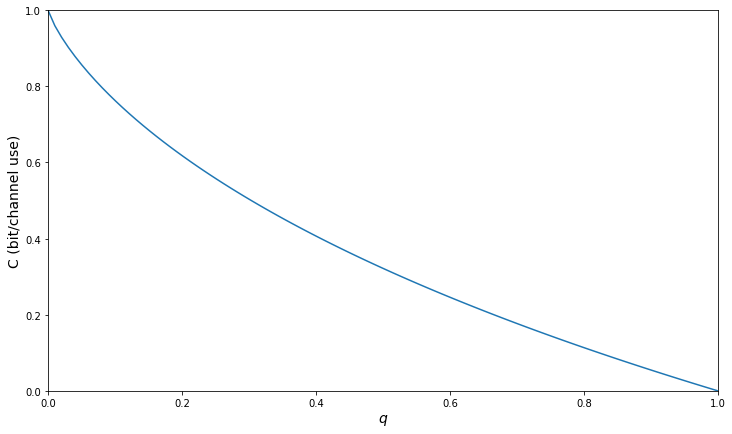

In [8]:
plt.figure(figsize=(12,7))
plt.plot(qs, Cs)
plt.xlim((0,1))
plt.ylim((0,1))
plt.xlabel('$q$',fontsize=14)
plt.ylabel('C (bit/channel use)',fontsize=14)

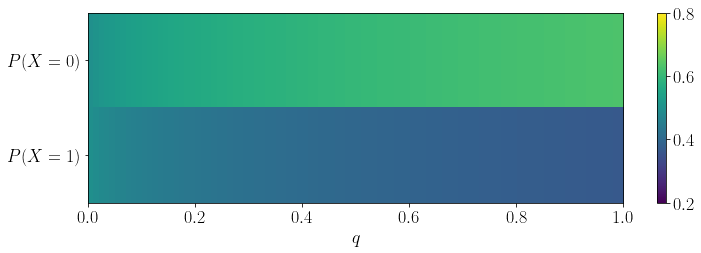

In [13]:
plt.figure(figsize=(12,3.5))
font = {'size'   : 18}
plt.rc('font', **font)
#plt.rc('text', usetex=True)
plt.imshow(pxs.T, extent=[0, qs[-1], -1, 1], aspect='auto', vmin=0.2, vmax=0.8)
plt.xlim(0,1)
plt.xlabel('$q$')
plt.yticks([-0.5, 0.5], ('$P(X=1)$', '$P(X=0)$'))
plt.colorbar();
#plt.savefig('Zchannel_input_distribution.pdf',bbox_inches='tight')